# Business goal:
- Perform data analysis.
- Identify predictors affecting sales.
- Offer a binary classification model for customers / buyers.
- Segment customers.

### Import libraries, configure pandas

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import warnings
warnings.filterwarnings('ignore')
import datetime

import pandas_summary as ps
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('use_inf_as_na', True)
random_state = 17

# Legend:
We are an online store of sports goods: clothing, shoes, accessories and sports nutrition. On the main page of the store we show users banners in order to stimulate their sales. Now one of 5 banners is randomly displayed there. Each banner advertises a specific product or the entire company. Our marketers believe that the experience with banners can vary by segment, and their effectiveness may depend on the characteristics of user behavior.
The manager of the company had an offer from partners to sell this place for a banner and advertise another service there (payment is assumed according to the CPC model).
Help the manager make a decision.

In [3]:
full_df = pd.read_csv('product.csv', sep=',')
full_df.shape

(8471220, 8)

# Data Description:
You have information about which banner appeared to the user, whether he clicked on it, as well as information about user purchases.
* order_id - unique purchase number (NA for banner clicks and impressions)
* user_id - unique identifier of the client
* page_id - unique page number for event bundle (NA for purchases)
* product - banner / purchase product
* site_version - version of the site (mobile or desktop)
* time - time of the action
* title - type of event (show, click or purchase)
* target - target class

In [4]:
full_df.head()

,order_id,user_id,page_id,product,site_version,time,title,target
0,cfcd208495d565ef66e7dff9f98764da,c81e728d9d4c2f636f067f89cc14862c,6f4922f45568161a8cdf4ad2299f6d23,sneakers,desktop,2019-01-11 09:24:43,banner_click,0
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,4e732ced3463d06de0ca9a15b6153677,sneakers,desktop,2019-01-09 09:38:51,banner_show,0
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,5c45a86277b8bf17bff6011be5cfb1b9,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:58:18,banner_show,0
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:59:15,banner_click,0


Предобратка to_datetime для разведки

In [5]:
full_df['time'] = full_df['time'].apply(pd.to_datetime)

## EDA

In [6]:
dfs = ps.DataFrameSummary(full_df)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

categoricals:  ['user_id', 'page_id', 'product', 'title']
numerics:  []


,order_id,user_id,page_id,product,site_version,time,title,target
count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.47122e+06
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0293608
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.168816
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
counts,8471220,8471220,8471220,8471220,8471220,8471220,8471220,8471220
uniques,8471220,4254619,7393316,5,2,5799549,3,2


In [7]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8471220 entries, 0 to 8471219
Data columns (total 8 columns):
order_id        object
user_id         object
page_id         object
product         object
site_version    object
time            datetime64[ns]
title           object
target          int64
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 517.0+ MB


Check NaN.

In [8]:
full_df.isnull().sum()

order_id        0
user_id         0
page_id         0
product         0
site_version    0
time            0
title           0
target          0
dtype: int64

* is_Buy - бинарная фича на основе fillna для page_id (1 для покупок)
* +Доп проверка на качество данных

order_id
1    8471220
dtype: int64


page_id
1    8471220
dtype: int64


title
banner_show     7393314
banner_click     829184
order            248722
dtype: int64


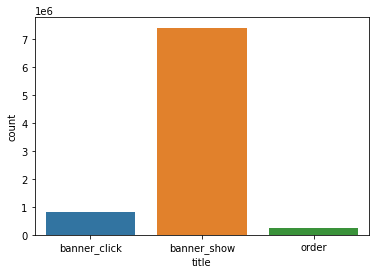

In [9]:
for i in ('order_id', 'page_id'):
    full_df[i] = full_df[i].fillna(0).apply(lambda x: x if x == 0 else 1)
    print(full_df.groupby([i]).size().sort_values(ascending=False).head(2))
    print('\n')
print(full_df.groupby(['title']).size().sort_values(ascending=False).head())
sns.countplot('title', data=full_df)
plt.show();
full_df.drop(['order_id', 'page_id'], axis=1, inplace=True)

In [10]:
full_df.head()

,user_id,product,site_version,time,title,target
0,c81e728d9d4c2f636f067f89cc14862c,sneakers,desktop,2019-01-11 09:24:43,banner_click,0
1,eccbc87e4b5ce2fe28308fd9f2a7baf3,sneakers,desktop,2019-01-09 09:38:51,banner_show,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,company,desktop,2019-01-03 08:58:18,banner_show,0
4,eccbc87e4b5ce2fe28308fd9f2a7baf3,company,desktop,2019-01-03 08:59:15,banner_click,0


Generate 2 binary features
* is_banner_click - 1, if ever a client clicked on a banner
* is_first_conversion - 1, if the first is a client visit

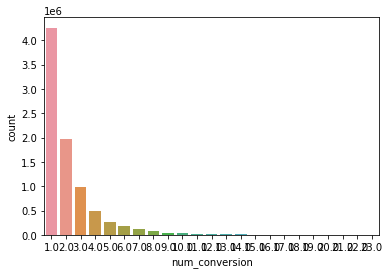

In [11]:
full_df = full_df.assign(num_conversion=full_df.groupby(['user_id'])['time'].rank(method='first', ascending=True))
sns.countplot('num_conversion', data=full_df)
plt.show();
full_df['IsBanner_click'] = full_df['title'].apply(lambda x: 1 if x == 'banner_click' else 0)
full_df['IsBanner_click'] = full_df.groupby('user_id').IsBanner_click.transform(np.mean).apply(lambda x: 0 if x == 0 else 1)
full_df['IsFirst_conversion'] = full_df['num_conversion'].apply(lambda x: 1 if x == 1 else 0)
full_df.drop(['user_id', 'title'], axis=1, inplace=True)

In [12]:
full_df.head()

,product,site_version,time,target,num_conversion,IsBanner_click,IsFirst_conversion
0,sneakers,desktop,2019-01-11 09:24:43,0,1.0,1,1
1,sneakers,desktop,2019-01-09 09:38:51,0,4.0,1,0
2,sports_nutrition,desktop,2019-01-09 09:12:45,0,3.0,1,0
3,company,desktop,2019-01-03 08:58:18,0,1.0,1,1
4,company,desktop,2019-01-03 08:59:15,0,2.0,1,0


## Working with dates
- Seasonality (binary time_IsMorning, time_IsDaylight, time_IsEvening, time_IsNight)
- Time of day (binary time_IsWinter)
- Hour time_Hour
- Day number in the month time_Day
- Day number in the week time_Week_Day
- Year * 100 + Month time_Year_Month

In [13]:
full_df['time_IsMorning'] = full_df['time'].apply(lambda ts: 1 if (ts.hour >= 6) and (ts.hour < 10) else 0)
full_df['time_IsDaylight'] = full_df['time'].apply(lambda ts: 1 if (ts.hour >= 10) and (ts.hour < 16) else 0)
full_df['time_IsEvening'] = full_df['time'].apply(lambda ts: 1 if (ts.hour >= 16) and (ts.hour < 23) else 0)
full_df['time_Hour'] = full_df['time'].apply(lambda ts: ts.hour)
full_df['time_Day'] = full_df['time'].apply(lambda ts: ts.day)
full_df['time_Week_Day'] = full_df['time'].apply(lambda ts: datetime.date(ts.year, ts.month, ts.day).weekday() + 1)
full_df['time_Year_Month'] = full_df['time'].apply(lambda ts: ts.year * 100 + ts.month)
full_df.drop(['time'], axis=1, inplace=True)

In [14]:
full_df.head()

,product,site_version,target,num_conversion,IsBanner_click,IsFirst_conversion,time_IsMorning,time_IsDaylight,time_IsEvening,time_Hour,time_Day,time_Week_Day,time_Year_Month
0,sneakers,desktop,0,1.0,1,1,1,0,0,9,11,5,201901
1,sneakers,desktop,0,4.0,1,0,1,0,0,9,9,3,201901
2,sports_nutrition,desktop,0,3.0,1,0,1,0,0,9,9,3,201901
3,company,desktop,0,1.0,1,1,1,0,0,8,3,4,201901
4,company,desktop,0,2.0,1,0,1,0,0,8,3,4,201901


### Categorical features



product
clothes             1786438
company             1725056
sneakers            1703342
sports_nutrition    1634625
accessories         1621759
dtype: int64


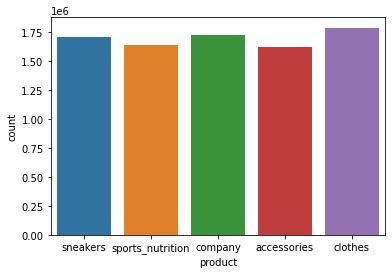



site_version
mobile     6088335
desktop    2382885
dtype: int64


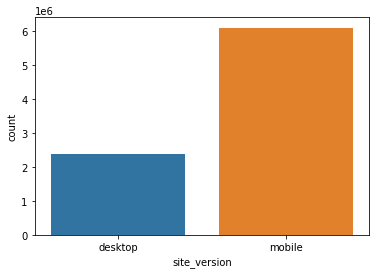

In [15]:
for i in ['product', 'site_version']:
    print('\n')
    print(full_df.groupby([i]).size().sort_values(ascending=False).head())
    sns.countplot(i, data=full_df)
    plt.show()

In [16]:
full_df['SV_IsMobile'] = full_df['site_version'].map({'desktop': 0, 'mobile': 1})
full_df.drop(['site_version'], axis=1, inplace=True)

* Applying one hot encoding to the 'product' attribute

In [17]:
full_df = pd.get_dummies(full_df, columns=['product'])

In [18]:
full_df.head()

,target,num_conversion,IsBanner_click,IsFirst_conversion,time_IsMorning,time_IsDaylight,time_IsEvening,time_Hour,time_Day,time_Week_Day,time_Year_Month,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition
0,0,1.0,1,1,1,0,0,9,11,5,201901,0,0,0,0,1,0
1,0,4.0,1,0,1,0,0,9,9,3,201901,0,0,0,0,1,0
2,0,3.0,1,0,1,0,0,9,9,3,201901,0,0,0,0,0,1
3,0,1.0,1,1,1,0,0,8,3,4,201901,0,0,0,1,0,0
4,0,2.0,1,0,1,0,0,8,3,4,201901,0,0,0,1,0,0


In [19]:
dfs = ps.DataFrameSummary(full_df)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

categoricals:  []
numerics:  ['num_conversion', 'time_Hour', 'time_Day', 'time_Week_Day', 'time_Year_Month']


,target,num_conversion,IsBanner_click,IsFirst_conversion,time_IsMorning,time_IsDaylight,time_IsEvening,time_Hour,time_Day,time_Week_Day,time_Year_Month,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition
count,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06,8.47122e+06
mean,0.0293608,2.18278,0.339944,0.502244,0.255898,0.309202,0.323469,12.3612,15.7065,3.98646,201903,0.718708,0.191443,0.210883,0.203637,0.201074,0.192962
std,0.168816,1.88616,0.47369,0.499995,0.436365,0.462165,0.4678,5.42247,8.62291,1.98917,1.42111,0.44963,0.393437,0.407936,0.402702,0.400803,0.394624
min,0,1,0,0,0,0,0,0,1,1,201901,0,0,0,0,0,0
25%,0,1,0,0,0,0,0,8,8,2,201902,0,0,0,0,0,0
50%,0,1,0,1,0,0,0,12,16,4,201903,1,0,0,0,0,0
75%,0,3,1,1,1,1,1,17,23,6,201905,1,0,0,0,0,0
max,1,23,1,1,1,1,1,23,31,7,201905,1,1,1,1,1,1
counts,8471220,8471220,8471220,8471220,8471220,8471220,8471220,8471220,8471220,8471220,8471220,8471220,8471220,8471220,8471220,8471220,8471220
uniques,2,23,2,2,2,2,2,24,31,7,5,2,2,2,2,2,2


## Great imbalance of the classes of the vector y 

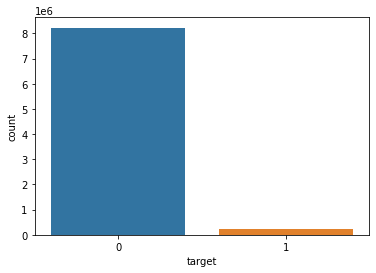

In [20]:
sns.countplot('target', data=full_df)
plt.show()

### Manual random-balancing of classes + Selection of matrix X and vector y

In [21]:
access_df = full_df.drop(['product_clothes', 'product_company', 'product_sneakers', 'product_sports_nutrition'], axis=1)

Perc. of banner click or show result:  0.5
Perc. of order result:  0.5
Total number of transactions in resampled data:  497444


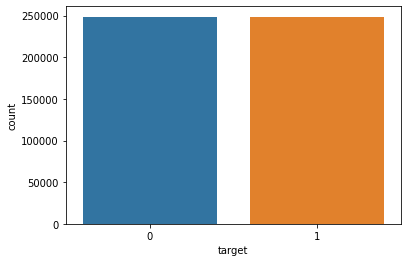

In [22]:
# Number of data points in the minority class
number_records_fraud = len(full_df[full_df.target == 1])
fraud_indices = np.array(full_df[full_df.target == 1].index)

# Picking the indices of the normal classes
normal_indices = full_df[full_df.target == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = full_df.iloc[under_sample_indices,:]

X = under_sample_data.ix[:, under_sample_data.columns != 'target']
y = under_sample_data.ix[:, under_sample_data.columns == 'target']

# Showing ratio
print("Perc. of banner click or show result: ", len(under_sample_data[under_sample_data.target == 0])/len(under_sample_data))
print("Perc. of order result: ", len(under_sample_data[under_sample_data.target == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))
sns.countplot('target', data=y)
plt.show()

In [23]:
X.shape, y.shape

((497444, 16), (497444, 1))

In [24]:
X.head()

,num_conversion,IsBanner_click,IsFirst_conversion,time_IsMorning,time_IsDaylight,time_IsEvening,time_Hour,time_Day,time_Week_Day,time_Year_Month,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition
60,5.0,1,0,0,1,0,10,3,7,201903,0,0,0,0,0,1
106,9.0,1,0,0,0,1,21,8,5,201902,0,0,0,0,1,0
107,10.0,1,0,0,0,1,19,10,7,201902,0,0,1,0,0,0
165,3.0,0,0,0,1,0,10,6,3,201902,1,0,0,0,0,1
179,1.0,1,1,0,0,1,19,10,7,201902,1,1,0,0,0,0


##### Data is balanced and ready for normalization

In [25]:
X.describe()

,num_conversion,IsBanner_click,IsFirst_conversion,time_IsMorning,time_IsDaylight,time_IsEvening,time_Hour,time_Day,time_Week_Day,time_Year_Month,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition
count,497444.000000,497444.000000,497444.000000,497444.000000,497444.000000,497444.000000,497444.000000,497444.000000,497444.000000,497444.000000,497444.000000,497444.000000,497444.000000,497444.000000,497444.000000,497444.000000
mean,2.429715,0.408635,0.445819,0.196237,0.302766,0.334410,12.499437,15.707097,3.987995,201903.226657,0.596256,0.185607,0.328654,0.104946,0.235699,0.145094
std,2.052944,0.491582,0.497056,0.397150,0.459455,0.471784,6.030023,8.685995,1.989665,1.382340,0.490648,0.388789,0.469724,0.306485,0.424435,0.352196
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,201901.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,8.000000,2.000000,201902.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,16.000000,4.000000,201903.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,17.000000,23.000000,6.000000,201904.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,31.000000,7.000000,201905.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Normalization of matrix X

In [26]:
stand_X = pd.DataFrame(preprocessing.scale(X), columns=X.columns)

### Python class for quick analysis of a feature set.

- withdrawal of the rating of signs on simple algorithms "out of the box" + average rating
- test of the current feature set on simple models without selection of hyperparameters and regularization

#### testing of simple models (including KNN) I do under the need to show precedents - it is important for business

In [27]:
class Feat_Importance:
    df = None
    columns = None
    random_state = None
    ranks = {}
        
    def __init__(self, X, y, columns, random_state=56, show_dict='N', show_plot='N'):
        self.X = X
        self.y = y
        self.names = columns
        self.random_state = random_state
        self.show_dict = show_dict
        self.show_plot = show_plot
        
    def __rank_to_dict(self, ranks, names, order=1):
        minmax = MinMaxScaler()
        ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
        ranks = map(lambda x: round(x, 2), ranks)
        return dict(zip(names, ranks))
    
    def feat_stats(self):
        self.ranks = {}
        self.get_KBest()
        self.get_LogReg()
        self.get_XGBC()
        
    def get_KBest(self):
        selector = SelectKBest(f_classif)
        selector.fit(self.X, self.y)
        scores = selector.scores_
        scores = pd.Series(scores).fillna(0)
        self.ranks["KBest"] = self.__rank_to_dict(scores, self.names)
        if self.show_dict == 'Y': 
            print('===== KBest dict =====\n', self.ranks["KBest"], '\n\n\n')
        if self.show_plot == 'Y': 
            print('===== KBest plot =====\n', self.X.shape)
            plt.bar(range(len(self.names)), -np.log10(selector.pvalues_))
            plt.xticks(range(len(self.names)), self.names, rotation='vertical');
            
    def get_LogReg(self):
        model_LogRegRidge = LogisticRegression(penalty='l2', C=0.15, 
                                               random_state=self.random_state, solver='liblinear', 
                                               n_jobs=-1)
        model_LogRegRidge.fit(self.X, self.y)
        self.ranks["LogRegRidge"] = self.__rank_to_dict(list(map(float, 
                                    model_LogRegRidge.coef_.reshape(len(self.names), -1))),
                                    self.names, order=1)
        
        if self.show_dict == 'Y': 
            print('===== LogRegRidge dict =====\n', self.ranks["LogRegRidge"], '\n\n\n')
        if self.show_plot == 'Y':
            print('===== LogRegRidge plot =====\n', self.X.shape)
            listsRidge = sorted(self.ranks["LogRegRidge"].items(), key=operator.itemgetter(1))
            dfRidge = pd.DataFrame(np.array(listsRidge).reshape(len(listsRidge), 2),
                       columns=['Features', 'Ranks']).sort_values('Ranks')
            dfRidge['Ranks'] = dfRidge['Ranks'].astype(float)
            dfRidge.plot.bar(x='Features', y='Ranks', color='blue')
            plt.xticks(rotation=90)
    
    def get_XGBC(self):
        model_XGBC = XGBClassifier(objective='binary:logistic',
                           max_depth=7, min_child_weight=5,
                           gamma=0, random_state=random_state, n_jobs=-1,
                           learning_rate=0.1, n_estimators=200)
        model_XGBC.fit(self.X, self.y)
        self.ranks["XGBC"] = self.__rank_to_dict(model_XGBC.feature_importances_, self.names)
        if self.show_dict == 'Y': 
            print('===== XGBClassifier dict =====\n', self.ranks["XGBC"], '\n\n\n')
        if self.show_plot == 'Y':
            print('===== XGBClassifier plot =====\n', self.X.shape)
            plot_importance(model_XGBC)
            plt.show()
    
    def stats_df(self):
        r = {}
        for name in self.names:
            r[name] = round(np.mean([self.ranks[method][name] for method in self.ranks.keys()]), 2)
        methods = sorted(self.ranks.keys())
        self.ranks['Mean'] = r
        methods.append('Mean')

        row_index, AllFeatures_columns = 0, ['Feature', 'Scores']
        AllFeats = pd.DataFrame(columns=AllFeatures_columns)
        for name in self.names:
            AllFeats.loc[row_index, 'Feature'] = name
            AllFeats.loc[row_index, 'Scores'] = [self.ranks[method][name] for method in methods]
            row_index += 1
        AllFeatures_only = pd.DataFrame(AllFeats.Scores.tolist(), )
        AllFeatures_only.rename(columns={0: 'KBest', 1: 'LogRegRidge', 2: 'XGB Classifier', 3: 'Mean'}, inplace=True)
        AllFeatures_only = AllFeatures_only[['KBest', 'LogRegRidge', 'XGB Classifier', 'Mean']]
        AllFeatures_compare = AllFeats.join(AllFeatures_only).drop(['Scores'], axis=1)
        return AllFeatures_compare
    
    def simple_test(self):
        x_train, x_valid, y_train, y_valid = train_test_split(self.X, self.y, test_size=0.3, random_state=random_state+37)
        mods = ('BernoulliNB', 'KNeighborsClassifier', 'RandomForestClassifier')
        for nu, model in enumerate([BernoulliNB(), KNeighborsClassifier(n_jobs=-1), 
                      RandomForestClassifier(n_jobs=-1)]):
            model.fit(x_train, y_train)
            predicted = model.predict(x_valid)
            print(mods[nu])
            print('------ accuracy ------\n', metrics.accuracy_score(y_valid, predicted))
            #print('------ confusion_matrix ------\n', metrics.confusion_matrix(y_valid, predicted))
            print('------ roc_auc_score ------\n', metrics.roc_auc_score(y_valid, predicted))
            print('\n')

In [28]:
fi = Feat_Importance(stand_X, y, stand_X.columns)
fi.feat_stats()
fi_df = fi.stats_df()
display(fi_df.sort_values(by=['Mean'], ascending=[False]))

,Feature,KBest,LogRegRidge,XGB Classifier,Mean
13,product_company,1.00,0.00,1.00,0.67
12,product_clothes,0.57,1.00,0.04,0.54
10,SV_IsMobile,0.58,0.54,0.07,0.40
1,IsBanner_click,0.16,0.90,0.05,0.37
14,product_sneakers,0.06,0.93,0.01,0.33
0,num_conversion,0.13,0.81,0.01,0.32
15,product_sports_nutrition,0.15,0.79,0.03,0.32
11,product_accessories,0.00,0.87,0.00,0.29
2,IsFirst_conversion,0.11,0.73,0.00,0.28
6,time_Hour,0.00,0.82,0.01,0.28


##### Remove obviously weak signs by the condition 'Mean'> 0.21

In [29]:
stand_X = stand_X[fi_df[fi_df['Mean'] > 0.21].Feature.values]
stand_X.shape

(497444, 14)

In [30]:
fi = Feat_Importance(stand_X, y, stand_X.columns)
fi.feat_stats()
fi_df = fi.stats_df()
display(fi_df.sort_values(by=['Mean'], ascending=[False]))

,Feature,KBest,LogRegRidge,XGB Classifier,Mean
11,product_company,1.00,0.00,1.00,0.67
10,product_clothes,0.57,1.00,0.03,0.53
8,SV_IsMobile,0.58,0.54,0.08,0.40
1,IsBanner_click,0.16,0.90,0.04,0.37
12,product_sneakers,0.06,0.93,0.01,0.33
0,num_conversion,0.13,0.81,0.01,0.32
13,product_sports_nutrition,0.15,0.79,0.03,0.32
3,time_IsMorning,0.19,0.65,0.02,0.29
9,product_accessories,0.00,0.87,0.00,0.29
2,IsFirst_conversion,0.11,0.73,0.00,0.28


In [31]:
fi.simple_test()

BernoulliNB
------ accuracy ------
 0.7125789029309675
------ roc_auc_score ------
 0.7124965662987421


KNeighborsClassifier
------ accuracy ------
 0.728647627216318
------ roc_auc_score ------
 0.7286168439490048


RandomForestClassifier
------ accuracy ------
 0.7201509039495021
------ roc_auc_score ------
 0.7201268781739323




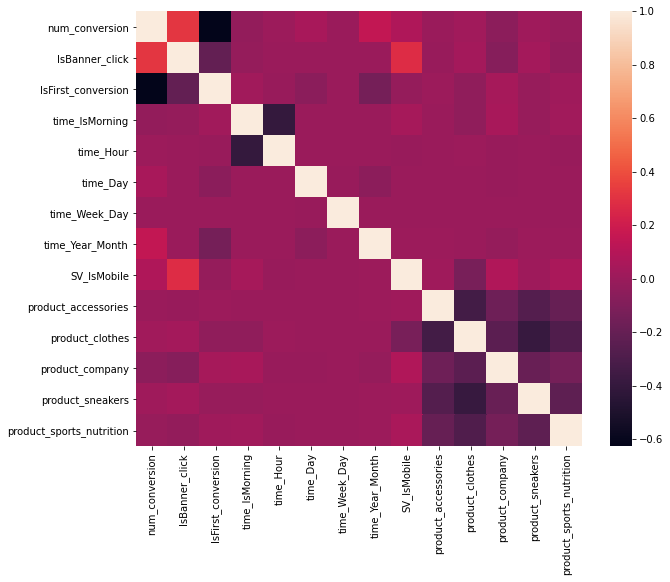

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(stand_X.corr(), xticklabels=stand_X.columns, yticklabels=stand_X.columns)

### Seaborn correlation matrix

The correlation matrix looks critical.
- After analyzing the correlation of the pandas dataframe object and the table of the influence of attributes on the model, remove features with high correlation values.

In [33]:
stand_X = stand_X.drop(['IsFirst_conversion'], axis=1)

### There is no critical correlation in the current feature set.

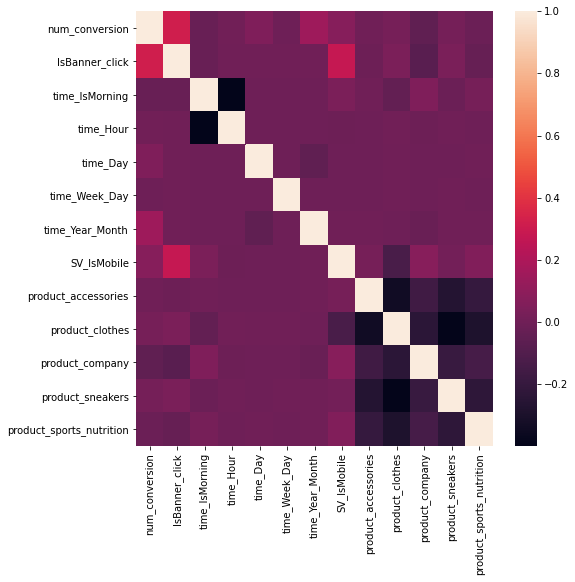

In [34]:
plt.figure(figsize=(8, 8))
sns.heatmap(stand_X.corr(), xticklabels=stand_X.columns, yticklabels=stand_X.columns)

### Test the current feature set.

In [35]:
fi = Feat_Importance(stand_X, y, stand_X.columns)
fi.feat_stats()
fi_df = fi.stats_df()
display(fi_df.sort_values(by=['Mean'], ascending=[False]))

,Feature,KBest,LogRegRidge,XGB Classifier,Mean
10,product_company,1.00,0.00,1.00,0.67
9,product_clothes,0.57,1.00,0.03,0.53
7,SV_IsMobile,0.58,0.54,0.08,0.40
1,IsBanner_click,0.16,0.90,0.04,0.37
11,product_sneakers,0.06,0.93,0.01,0.33
0,num_conversion,0.13,0.83,0.01,0.32
12,product_sports_nutrition,0.15,0.79,0.02,0.32
2,time_IsMorning,0.19,0.65,0.02,0.29
8,product_accessories,0.00,0.87,0.00,0.29
3,time_Hour,0.00,0.73,0.01,0.25


In [36]:
fi.simple_test()

BernoulliNB
------ accuracy ------
 0.7193266949890775
------ roc_auc_score ------
 0.7192439748390713


KNeighborsClassifier
------ accuracy ------
 0.7272337403004677
------ roc_auc_score ------
 0.7272030663470379


RandomForestClassifier
------ accuracy ------
 0.7197287481405041
------ roc_auc_score ------
 0.719704895419604




### Split into test and validation samples

In [37]:
x_train, x_valid, y_train, y_valid = train_test_split(stand_X, y, test_size=0.3, random_state=random_state)


### Test the current set of features on effective models with the selection of hyperparameters.

* Random forest

In [38]:
r_for = RandomForestClassifier()
print(r_for)
for_params = {'max_depth': np.arange(4, 10), 'max_features': np.arange(0.25, 0.5, 1), 'n_estimators': [30, 50, 60]}
for_grid = GridSearchCV(r_for, for_params, cv=2, n_jobs=-1)
for_grid.fit(x_train, y_train)
print('best score / best params: ', for_grid.best_score_, for_grid.best_params_)
y_pred = for_grid.predict(x_valid)
print('classification_report: \n', metrics.classification_report(y_pred, y_valid))
print('accuracy_score: ', metrics.accuracy_score(y_pred, y_valid))
print('roc_auc_score: ', metrics.roc_auc_score(y_pred, y_valid))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
best score / best params:  0.7591941644409983 {'max_depth': 9, 'max_features': 0.25, 'n_estimators': 30}
classification_report: 
               precision    recall  f1-score   support

           0       0.71      0.78      0.74     67329
           1       0.81      0.74      0.77     81905

    accuracy                           0.76    149234
   macro avg       0.76      0.76      0.76    149234
weighted avg       0.76      0.76      0.76    1492

* Logistic regression

In [39]:
log_r = LogisticRegression()
grid_values = {'penalty': ['l2'], 'C': [0.0001, 0.001, 0.01, 0.1]}
lr_grid = GridSearchCV(log_r, param_grid=grid_values, cv=2, n_jobs=-1)
lr_grid.fit(x_train, y_train)
print('best score / best params: ', lr_grid.best_score_, lr_grid.best_params_)
y_pred = lr_grid.predict(x_valid)
print('classification_report: \n', metrics.classification_report(y_pred, y_valid))
print('accuracy_score: ', metrics.accuracy_score(y_pred, y_valid))
print('roc_auc_score: ', metrics.roc_auc_score(y_pred, y_valid))

best score / best params:  0.7304930932483271 {'C': 0.1, 'penalty': 'l2'}
classification_report: 
               precision    recall  f1-score   support

           0       0.69      0.75      0.72     68970
           1       0.77      0.71      0.74     80264

    accuracy                           0.73    149234
   macro avg       0.73      0.73      0.73    149234
weighted avg       0.73      0.73      0.73    149234

accuracy_score:  0.7292239034000295
roc_auc_score:  0.7303994783720898


* Gradient boosting

In [40]:
xgb_m = XGBClassifier()
xgb_params = [
    {"n_estimators": [300, 350],
     "max_depth": [3,  5],
     "learning_rate": [0.01, 0.05]}
]
xgb_grid = GridSearchCV(xgb_m, xgb_params, cv=2, refit=True, verbose=1, n_jobs=-1)
xgb_grid.fit(x_train, y_train)
print('best score / best params: ', xgb_grid.best_score_, xgb_grid.best_params_)
y_pred = xgb_grid.predict(x_valid)
print('classification_report: \n', metrics.classification_report(y_pred, y_valid))
print('accuracy_score: ', metrics.accuracy_score(y_pred, y_valid))
print('roc_auc_score: ', metrics.roc_auc_score(y_pred, y_valid))

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  5.2min finished


best score / best params:  0.7659515809425347 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}
classification_report: 
               precision    recall  f1-score   support

           0       0.72      0.79      0.76     68063
           1       0.81      0.75      0.78     81171

    accuracy                           0.77    149234
   macro avg       0.77      0.77      0.77    149234
weighted avg       0.77      0.77      0.77    149234

accuracy_score:  0.7662731013039924
roc_auc_score:  0.7681749224444703


## Conclusions

Enhanced sample clustering. The goal is to blur product_company in one cluster.

In [41]:
cluster_stand_df = stand_X
cluster_stand_df['target'] = preprocessing.scale(y)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=random_state).fit(cluster_stand_df)
unique, counts = np.unique(kmeans.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0 117247]
 [     1 163487]
 [     2 216710]]


In [42]:
cluster_df = X[[i for i in stand_X.columns if i != 'target']]
cluster_df['target'] = y
cluster_df['Cluster'] = kmeans.labels_ # 497444

In [43]:
cluster_df['Cluster'].value_counts(normalize=True)

2    0.435647
1    0.328654
0    0.235699
Name: Cluster, dtype: float64

* Cluster 3 - customer share 23.53%. The share of “buying” customers is 0.69. Customers buying product_clothes and most often clicking on the banner.
* Cluster 1 - customer share 32.85%. The proportion of "buying" customers is 0.578. The most conversions. The largest share of desktop users.
* Cluster 0 - customer share 43.61%. The share of "buying" customers is 0.315. Customers in the categories product_accessories, product_company, product_sports_nutrition. Least click and order products. The target audience. The largest share of "mobile" users. Perhaps the banner is not very attractive in the mobile version.

In [44]:
cluster_df.groupby('Cluster').mean().sort_values(by=['target'], ascending=False)

,num_conversion,IsBanner_click,time_IsMorning,time_Hour,time_Day,time_Week_Day,time_Year_Month,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition,target
Cluster,,,,,,,,,,,,,,
1,2.503153,0.437087,0.173145,12.553781,15.733379,3.991394,201903.222874,0.507117,0.000000,1.0,0.000000,0.0,0.000000,0.689443
0,2.500661,0.440446,0.185830,12.523553,15.711404,3.992042,201903.238812,0.609849,0.000000,0.0,0.000000,1.0,0.000000,0.577576
2,2.335928,0.369960,0.219288,12.445392,15.684938,3.983240,201903.222934,0.656149,0.426049,0.0,0.240898,0.0,0.333053,0.315112


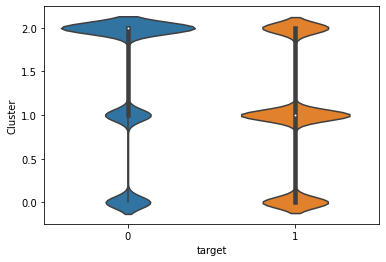

In [45]:
ax = sns.violinplot(x='target', y='Cluster',
                         data=cluster_df, height=4, aspect=.7)
plt.show();

In [46]:
display(fi_df.sort_values(by=['Mean'], ascending=[False]))

,Feature,KBest,LogRegRidge,XGB Classifier,Mean
10,product_company,1.00,0.00,1.00,0.67
9,product_clothes,0.57,1.00,0.03,0.53
7,SV_IsMobile,0.58,0.54,0.08,0.40
1,IsBanner_click,0.16,0.90,0.04,0.37
11,product_sneakers,0.06,0.93,0.01,0.33
0,num_conversion,0.13,0.83,0.01,0.32
12,product_sports_nutrition,0.15,0.79,0.02,0.32
2,time_IsMorning,0.19,0.65,0.02,0.29
8,product_accessories,0.00,0.87,0.00,0.29
3,time_Hour,0.00,0.73,0.01,0.25


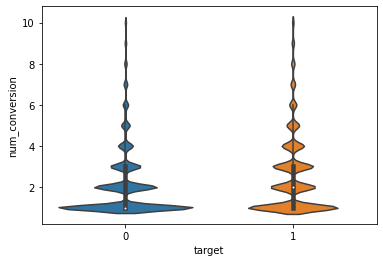

In [47]:
ax = sns.violinplot(x='target', y='num_conversion',
                         data=cluster_df[cluster_df['num_conversion'] <= 10], height=4, aspect=.7)
plt.show();

- IsBanner_click - people who have ever clicked on a banner (without an order) are more likely to make a purchase.
- time_IsMorning - in the morning, shopping activity is low.

IsBanner_click


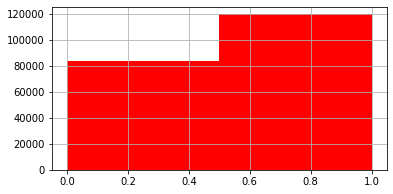

time_IsMorning


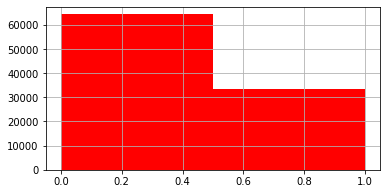

SV_IsMobile


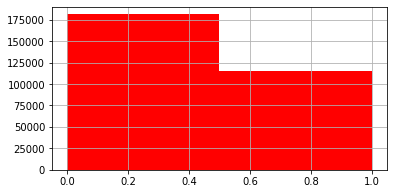

In [48]:
feat = [f for f in cluster_df.columns if 'Is' in f]
for i in feat:
    print(i)
    plt.figure()
    tmp = cluster_df[cluster_df[i] == 1]
    tmp['target'].hist(figsize=(6, 3), bins=2, color = 'red')
    plt.show();

The most significant features:
- time_Day - buy more at the end of the month.
- time_Hour - buy more at night.
- time_Year_Month - Shopping activity increases in the months with fewer weekends and holidays.

time_IsMorning


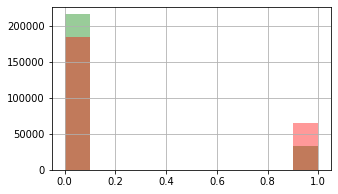

time_Hour


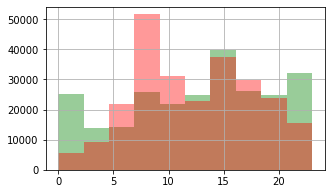

time_Day


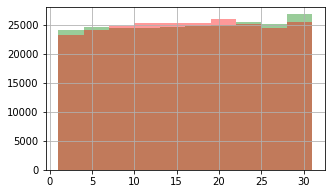

time_Week_Day


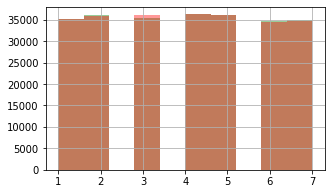

time_Year_Month


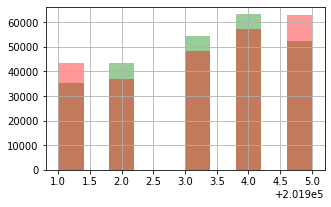

In [49]:
feat = [f for f in cluster_df.columns if 'time' in f]
for i in feat:
    print(i)
    plt.figure()
    cluster_df[cluster_df['target'] == 1][i].hist(figsize=(5, 3), alpha=0.4, color = 'green')
    cluster_df[cluster_df['target'] == 0][i].hist(figsize=(5, 3), alpha=0.4, color = 'red')
    plt.show();

- product_clothes - product_clothes is most actively sold, the largest number of banner impressions.
- product_sneakers - 2nd product in terms of popularity and sales.
- product_accessories and product_sports_nutrition need to research sales figures, add features.

product_accessories


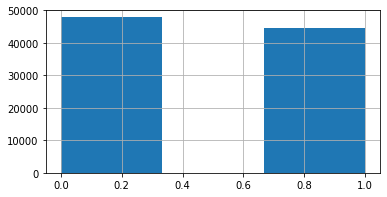

product_clothes


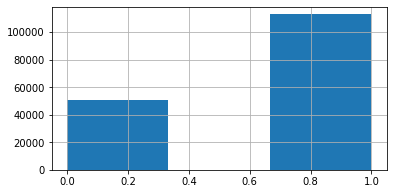

product_sneakers


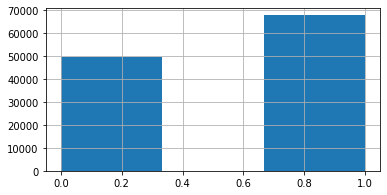

product_sports_nutrition


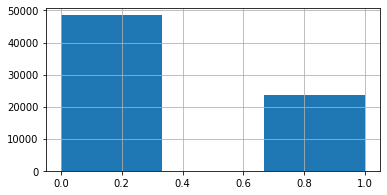

In [50]:
feat = [f for f in cluster_df.columns if 'product' in f and '_company' not in f]
for i in feat:
    print(i)
    plt.figure()
    tmp = cluster_df[cluster_df[i] == 1]
    tmp['target'].hist(figsize=(6, 3), bins=3)
    plt.show();